In [ ]:
#@title Imports
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from keras.optimizers import adam_v2

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding, create_optimizer, TFBertModel, BertConfig
from datasets import Dataset, DatasetDict

In [ ]:
# load dataframe, delete article link column
pd.set_option('display.max_colwidth', None)
# there are v1 and v2
file_name = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(file_name, lines=True)
del df['article_link']
df.head(5)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0


In [ ]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

# Preprocessing

## Data cleaning

In [ ]:
appos = {
        "aren't": "are not", "can't": "cannot", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not",
        "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'll": "he will", "he's": "he is",
        "I'd": "I had", "I'll": "I will", "I'm": "I am", "I've": "I have", "isn't": "is not", "let's": "let us", "mightn't": "might not",
        "mustn't": "must not", "shan't": "shall not", "she'd": "she had", "she'll": "she will", "she's": "she is", "shouldn't": "should not",
        "what's": "what is", "there's": "there is", "they'd": "they had", "they'll": "they will", "they've": "they have",
        "we'd": "we had", "we're": "we are", "we've": "we have", "weren't": "were not",
}
def transform_appos(headline):
    arr = []
    for row in headline.values:
        for word in row:
            if word in appos.keys():
                row = row.replace(word, appos[word])
    return headline

def to_lowercase(headline):
    headline = headline.apply(lambda x: x.lower())
    return headline

def remove_whitespaces(headline):
    headline = headline.str.strip()
    return headline

def replace_quote(headline):
    headline = headline.str.replace("’", "'")
    return headline

def preprocess(headlines: pd.Series):
    headlines = to_lowercase(headlines)
    headlines = replace_quote(headlines)
    headlines = transform_appos(headlines)
    return headlines

In [ ]:
# apply preprocessing to the whole dataset
df['headline'] = preprocess(df['headline'])

## Preprocessing for huggingface

In [ ]:
# MAX_SEQUENCE_LENGTH = 128
EMBEDDING_DIM = BertConfig().hidden_size

In [ ]:
def create_datasets_from_dataframe(df: pd.DataFrame):
    # split data into train and test set into 60:20:20
    train_df, test_df = train_test_split(df, train_size=0.6, shuffle=True, random_state=0)
    val_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=0)

    # create dataset objects 
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)

    # create dataset dict with dataset objects
    datasets = DatasetDict()
    datasets['train'] = train_dataset
    datasets['val'] = val_dataset
    datasets['test'] = test_dataset
    return datasets

datasets = create_datasets_from_dataframe(df)

In [ ]:
# first sentence
print(datasets['train'][0])
print(tokenizer(datasets['train'][0]['headline']))

{'headline': "bernice king says trump's racist comments are 'troubling to our humanity'", 'is_sarcastic': 0, '__index_level_0__': 17847}
{'input_ids': [101, 16595, 6610, 2332, 2758, 8398, 1005, 1055, 16939, 7928, 2024, 1005, 19817, 7140, 9709, 2000, 2256, 8438, 1005, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
ids = tokenizer(datasets['train']['headline'])['input_ids']
min([len(id) for id in ids])

4

In [ ]:
# tokenize, padd, truncate
def tokenize_function(item):
    return tokenizer(item['headline'],
                     padding=True,
                     truncation=True)

tokenized_datasets = datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
def convert_dataset_to_tf_dataset(dataset: Dataset):
    tf_dataset = dataset.to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["is_sarcastic"],
        shuffle=False,
        collate_fn=data_collator,
        batch_size=128,
    )
    return tf_dataset

tf_train_dataset = convert_dataset_to_tf_dataset(tokenized_datasets['train'])
tf_val_dataset = convert_dataset_to_tf_dataset(tokenized_datasets['val'])
tf_test_dataset = convert_dataset_to_tf_dataset(tokenized_datasets['test'])

In [ ]:
# find MAX_SEQUENCE_LENGTH based on len(input_ids)
from typing import List
def find_max_seq_len(datasets: List[Dataset]):
  max_len = 0
  for dataset in datasets:
    for x, y in dataset:
      if x['input_ids'].shape[1] > max_len:
        max_len = x['input_ids'].shape[1]
  return max_len

MAX_SEQUENCE_LENGTH = find_max_seq_len([tf_train_dataset, tf_val_dataset, tf_test_dataset])

# Create and train model

In [ ]:
num_of_epochs = 5

# callbacks
stop_early = EarlyStopping(monitor='val_loss', patience=3)

# no need to save best weights, huggingface is already saving the best weights when save_pretrained() is called
save_best_weights = ModelCheckpoint('checkpoints/bert', 
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=True)

In [ ]:
def model_builder() -> Model:
    # create inputs 
    # (shape=(None,)) means: model accepts sequences in any length. Super useful for dynamic padding
    inputs = [
        Input(shape=(None,), dtype=tf.int32, name='input_ids'),
        Input(shape=(None,), dtype=tf.int32, name='attention_mask'),
        Input(shape=(None,), dtype=tf.int32, name='token_type_ids')
    ]

    # load pretrained bert without classification head
    bert_base = TFBertModel.from_pretrained(model_name)
    
    # create outputs (custom classification head)
    cls = bert_base(inputs).last_hidden_state[:, 0, :]
    outputs = Dropout(rate=0.1, name='dropout1')(cls)
    outputs = Dense(units=EMBEDDING_DIM, activation='relu', name='dense1')(outputs)
    outputs = Dropout(rate=0.1, name='dropout1')(cls)
    outputs = Dense(units=128, activation='relu', name='dense2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name='binary_classification')(outputs)

    # create optizmier
    num_train_steps = len(tf_train_dataset) * num_of_epochs
    # warmup proportion is 0.1 -> https://arxiv.org/pdf/1905.05583.pdf
    num_warmup_steps = num_train_steps // 10 
    optimizer, _ = create_optimizer(init_lr=2e-5,
                                    num_train_steps= num_train_steps,
                                    num_warmup_steps=num_warmup_steps,
                                    min_lr_ratio=0)
    
    # create model
    model = Model(inputs, outputs)
    loss = BinaryCrossentropy()
    metrics=['acc']
    model.compile(optimizer, loss, metrics)

    return model

In [ ]:
model = model_builder()
history = model.fit(tf_train_dataset,
          validation_data=tf_val_dataset,
          epochs=num_of_epochs,
          callbacks=[stop_early, save_best_weights])

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
126/126 [==============================] - 150s 1s/step - loss: 0.4033 - acc: 0.8080 - val_loss: 0.2309 - val_acc: 0.9047
Epoch 2/5
126/126 [==============================] - 131s 1s/step - loss: 0.1844 - acc: 0.9280 - val_loss: 0.1985 - val_acc: 0.9203
Epoch 3/5
126/126 [==============================] - 126s 1s/step - loss: 0.1142 - acc: 0.9585 - val_loss: 0.2360 - val_acc: 0.9188
Epoch 4/5
126/126 [==============================] - 127s 1s/step - loss: 0.0676 - acc: 0.9780 - val_loss: 0.2641 - val_acc: 0.9182
Epoch 5/5
126/126 [==============================] - 128s 1s/step - loss: 0.0495 - acc: 0.9833 - val_loss: 0.2436 - val_acc: 0.9259


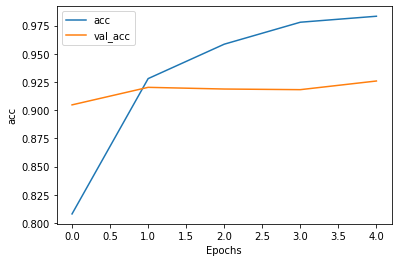

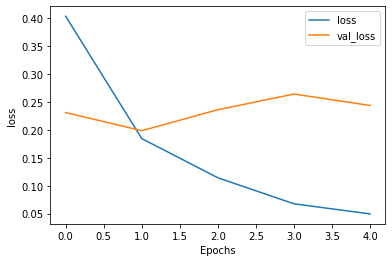

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

## Save, evaluate, predict

In [ ]:
saved_model_tf = model_builder()
saved_model_tf.load_weights('checkpoints/bert')
loss, acc = model.evaluate(tf_test_dataset)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


42/42 [==============================] - 15s 348ms/step - loss: 0.2575 - acc: 0.9238


In [ ]:
predictions = saved_model_tf.predict(tf_test_dataset)
y_pred = (predictions > 0.5).astype('int32')
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3014
           1       0.92      0.90      0.91      2328

    accuracy                           0.92      5342
   macro avg       0.92      0.92      0.92      5342
weighted avg       0.92      0.92      0.92      5342

